# An Emphatic Approach to the Problem of Off-policy Temporal-Difference Learning --- Richard S. Sutton, A. Rupam Mahmood and Martha White (2015)
 

In this IPython Notebook, I will walk through the various Function Approximation methods for estimating an optimal solution for the value functions V(s) given in the above mentioned paper. We get introduced to a different type of trace: the followon trace, interest function and also a new variant of Squared Value error with interest function!

The algorithms implemented in this notebook are:

1. Emphatic TD(lambda)
2. Emphatic TD(0)
3. Off-policy Semi-gradient TD(0) for estimating V_pi

The above alogorithms are compared with the follwing algorithms:

1. Gradient Monte Carlo Algorithm for Approximating V
2. Semi-gradient TD(0) for estimating V_pi
3. TD(lambda)
4. True-online TD(lambda)
5. TD(0) for prediction. This result will act as the V_pi(s) to calculate RMSVE





# Brief implementation details and metrics

1. The algorithms have been implemented for the GridWorld environment. The idea is to see the feasibility of the algorithms on environments which have not been explored in the paper or the text.
2. For function approximation, Fourier basis functions have been used as given. I have used 10 features for i=0 to i =9. A larger feature space tend to overfit.
3. The result from TD(0) for prediction act as the V_pi(s) to calculate RMSVE.
4. For the Root Mean Squared Value Error, I multiply the sqaured error by some time factor. In the equation it is denoted as d(s). Here, I define my own versin of d(s) where it denotes the number of times each state is visited. This d(s) is then multiplied by the squared error. This helps in setting the error proportionally for each state depending upon the frequency with which it occurs. d(s) has been normalized.
5. For the RMSVE, a new variant is also implemented as given in the paper. Apart from the terms stated in the abve point (4), we also add an extra term which is the "INTEREST FUNCTION".
6. An off-policy semi-gradient TD(0) is implemented to estimate the value of V_pi using Function Approximation. The behavior policy is "epsilon greedy policy" and the target policy is a "greedy policy".
7. Emphatic TD(0) is implmented as given in the equation below.
8. Emphatic TD(lambda) is implmented as given in the equation below.
9. The interest function is defined as a linear combination of the state features and is a vector of length 16. One value for each state.
10. Lambda and Gamma are also functions of the states.


# Equation for Emphatic TD(0) with followon trace

<img src="etd0.png">
<img src="etd0_1.png">

# Equation for Emphatic TD(lambda) with followon trace and an interest function

<img src="etd_lambda.png">

# RMSVE for Emphatic TD(lambda) with an interest function

<img src="rmsve.png">

# Experiments || Code


In [3]:
#import the libraries

%matplotlib inline

import gym
import math
import itertools
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import pylab
#import gym_maze

if "../" not in sys.path:
  sys.path.append("../") 

from collections import defaultdict
from lib import plotting

from lib.envs.gridworld import GridworldEnv

matplotlib.style.use('ggplot')




# Sample GridWorld Environment

In [4]:
#Environment

print "Gridworld Environment of 16 states and 4 actions\n"

print "A sample environment is given below:\n"

env = GridworldEnv()

print "state is", env.reset()

print "next_state and reward are",env.step(2)[0],"and" ,env.step(2)[1], "\n"

print "A snapshot of the environment\n"

env.render()



Gridworld Environment of 16 states and 4 actions

A sample environment is given below:

state is 15
next_state and reward are 15 and 0.0 

A snapshot of the environment

T  o  o  o
o  o  o  o
o  o  o  o
o  o  o  x


# Choose an epsilon greedy policy with epsilon=0.1 for Behavior Policy

In [5]:
def make_epsilon_greedy_policy(Q, epsilon, nA):
    """
    We choose an epsilon greedy policy here.
    This is a cool helper function adapted from the WildML blog. 
    """
    
    def policy_fn(observation):
        A = np.ones(nA, dtype=float) * epsilon / nA
        best_action = np.argmax(Q[observation])
        A[best_action] += (1.0 - epsilon)
        return A
    return policy_fn

# Create a Greedy Policy for Target Policy

In [6]:
def create_greedy_policy(Q):
    """
    Creates a greedy policy based on Q values.
    
    Args:
        Q: A dictionary that maps from state -> action values
        
    Returns:
        A function that takes an observation as input and returns a vector
        of action probabilities.
    """
    
    def policy_fn(observation):
        A = np.zeros_like(Q[observation], dtype=float)
        best_action = np.argmax(Q[observation])
        A[best_action] = 1.0
        return A
    return policy_fn

# On-policy Semi-gradient TD(0)

In [7]:
"""
semi_gradient_td_0
"""

def semi_gradient_td_0(env, num_episodes, alpha, discount_factor, epsilon):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
            
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    time_spent_state[k] += 1            
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            #update theta
            v_cap = np.dot(state_feature,theta)
            v_next_state = np.dot(next_state_feature,theta)
            grad_v_cap = state_feature
            
            theta = theta + alpha * (reward + discount_factor*v_next_state - v_cap) * grad_v_cap
            
                
            if done:
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
        
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
          
            
    
    
    
    return V, time_spent_state

# Sample run for On-policy Semi-gradient TD(0)

In [8]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 20

alpha = np.zeros([10])
alpha[0] = 0.01


eps = 0.1
gamma = 1

print "### Semi-gradient TD(0) for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent = semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

    


### Semi-gradient TD(0) for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 20 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-0.79154729 -0.84472866 -1.87261779 -3.07977513 -2.45367023 -2.03484841
 -3.24682996 -2.79421228 -0.75325052 -1.21267986 -2.7803245  -1.93555019
 -1.03308806 -1.99203734 -2.24150097 -1.76644758]
for alpha= 0.02 Approximate Optimal Value of the states is
[-0.69006029 -0.82017902 -0.69679464 -0.26536447 -0.57857261 -1.51610238
 -1.67091406 -0.9768967  -0.71631364 -1.21576108 -1.65282854 -1.48945994
 -0.91850833 -0.46996685 -0.43549512 -0.52145329]
for alpha= 0.03 Approximate Optimal Value of the states is
[-1.66985964 -2.25003141 -5.78140701 -9.20201552 -6.12917113 -2.092166
 -4.116472   -5.66498406 -2.72538724 -1.98978741 -3.42328285 -1.99320335
 -1.66093175 -5.16490146 -6.98727632 -6.60353782]
for alpha= 0.04 Approximate Optimal Value of the states is
[ 0.09994724 -1.29559728 -2.92293479 -2.20245281 -1.07959708 -1.392734

# Gradient Monte-Carlo Algorithm

In [9]:
"""
gradient_mc
"""

def gradient_mc(env, num_episodes, alpha, discount_factor, epsilon,length_episode):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        #print "episode number=", (i_episode+1)
 
            
        episode = np.zeros((length_episode,2))
        #print episode.shape
        
        state = env.reset()

        for t in range(len(episode)):

            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)
            next_state, reward, done, _ = env.step(action)
            episode[t,0]= next_state
            episode[t,1]= reward

            if done:
                break
            state = next_state
        
        #print "sampled trajectory is", ,episode , "\n"
        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
            
            
        G = 0

        
        # time step increment in the episode
        
        for t in range(len(episode)):
            G = gamma*G + episode[t,1]
            
            #time spent in states
            
            for k in range(len(time_spent_state)):
                if state == k:
                    time_spent_state[k] += 1
                    
                
            
            
            
            
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            #update theta
            v_cap = np.dot(state_feature,theta)
            grad_v_cap = state_feature
            
            theta = theta + alpha * (G - v_cap) * grad_v_cap
            
                
            if done:
                break
                
            state = next_state
            
    #calculate the final time factor
    
    for k in range(len(time_spent_state)):
        time_spent_state[k] = float(time_spent_state[k])/16
        
    
    
    
    #Calculate the V values for all the states
    
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
        
          

    
    return V, time_spent_state

# Sample run for Gradient Monte-Carlo Algorithm


In [10]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 10

alpha = np.zeros([10])
alpha[0] = 0.01


eps = 0.1
gamma = 1
length_episode = 10

print "### Gradient Monte-Carlo for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent_state = gradient_mc(env, n_episodes,alpha[i],gamma,eps,length_episode)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

    

### Gradient Monte-Carlo for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 10 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-1.69505878 -2.99897479 -4.33100969 -2.98988728 -0.9294033  -0.45034892
 -0.68852215 -0.59675267 -0.56692031 -0.66550852 -0.59560467 -0.56779615
 -0.65789466 -0.62843378 -0.52819617 -0.49475646]
for alpha= 0.02 Approximate Optimal Value of the states is
[-4.61686252 -5.55495383 -6.81434205 -5.72979833 -2.55812109 -0.58601635
 -0.99330027 -1.47088039 -1.02993258 -0.99843115 -1.32995812 -1.12055936
 -1.00231913 -1.28846336 -1.11406336 -0.8027302 ]
for alpha= 0.03 Approximate Optimal Value of the states is
[-2.28898647 -5.1681399  -6.96130745 -2.76314205 -0.03673    -1.44171991
 -1.35587276 -0.15468277 -0.97883557 -1.33206673 -0.39582904 -0.79862629
 -1.32016478 -0.54449314 -0.6681609  -1.31704587]
for alpha= 0.04 Approximate Optimal Value of the states is
[-2.87876351 -6.98507796 -9.55140593 -3.51217678  0.45949891 -1.693

# Semi Gradient TD(lambda)

In [11]:
"""
semi_gradient_td_lambda
"""

def semi_gradient_td_lambda(env, num_episodes, alpha, discount_factor, epsilon,lambda_input):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
        
        etrace = np.zeros(10)
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    
                    time_spent_state[k] += 1
                    
                    
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # eligibility trace vectors and theta
            grad_v_cap = state_feature
            v_cap = np.dot(state_feature,theta)
            v_next_state = np.dot(next_state_feature,theta)
            
            
            etrace = discount_factor * lambda_input * etrace + grad_v_cap
            delta = reward + discount_factor*v_next_state - v_cap
            
            
            
            theta = theta + alpha * delta * etrace
            
                
            if done:
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
    
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
          
            
    
    
    
    return V, time_spent_state

# Sample run for Semi-gradient TD(lambda) with eligibility traces

In [12]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 20

alpha = np.zeros([10])
alpha[0] = 0.01
lambda_input = 0.3

eps = 0.1
gamma = 1

print "### Semi-gradient TD(lambda) for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time = semi_gradient_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

### Semi-gradient TD(lambda) for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 20 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-1.55220959 -1.83627116 -3.26417628 -4.52068829 -3.53820009 -2.75868279
 -3.72043961 -2.97872208 -0.81517106 -1.49316397 -3.3220906  -2.73950296
 -2.31460092 -3.4571913  -3.12689153 -2.18690468]
for alpha= 0.02 Approximate Optimal Value of the states is
[-13.97434133 -16.47850928 -16.84217695 -11.50130726  -9.7603195
 -11.66697655  -9.2523747   -7.28424952 -11.66772963 -13.67348947
  -8.72176558  -6.4749244  -10.39767421 -12.08099714  -8.41610073
  -5.76971666]
for alpha= 0.03 Approximate Optimal Value of the states is
[-21.25571807 -21.83669897 -16.14832998  -5.22012477  -4.86838934
 -10.22763015  -5.52750885  -1.37936474 -11.33190225 -20.15802646
 -14.39405672  -5.97567273  -5.6169684   -8.81368285 -10.86712488
 -11.5418776 ]
for alpha= 0.04 Approximate Optimal Value of the states is
[-12.69134486 -13.7485207  -16

# TD(0) prediction for V_pi(s)

In [13]:
"""
td_0_v_pi
"""

def td_0_v_pi(env, num_episodes, alpha, discount_factor, epsilon):
    
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    V = np.zeros(env.nS)
    
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
   
            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            V[state] = V[state] + alpha * (reward + discount_factor*V[next_state] - V[state])
            
            
                
            if done:
                break
                
            state = next_state
    
    #Calculate the V values for all the states
    
    
    
    return V

# Sample run for TD(0) prediction for V_pi(s)

In [14]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 5000

alpha = np.zeros([10])

avg_reward_q = np.zeros([10])

eps = 0.1
gamma = 1

V_pi = td_0_v_pi(env, n_episodes,0.7,gamma,eps)
print "TD(0) prediction for V_pi(s)\n",V_pi

    


TD(0) prediction for V_pi(s)
[   0.           -8.18250307  -61.26475664 -163.33754732   -1.00015317
  -21.75463192 -116.94870529 -168.09300074   -2.009131    -20.55474531
  -59.30365375 -139.33715246   -3.12572569  -25.2523762   -64.98926665
    0.        ]


# True Online TD(lambda) with eligibility traces

In [15]:
"""
true_online_td_lambda
"""

def true_online_td_lambda(env, num_episodes, alpha, discount_factor, epsilon,lambda_input):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n)
    
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
        
        etrace = np.zeros(10)
        v_old = 0
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    
                    time_spent_state[k] += 1
                    
                    
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            # eligibility trace vectors and theta
            
            v = np.dot(state_feature,theta)
            v_cap = np.dot(next_state_feature,theta)
            grad_v = state_feature
            
            etrace = discount_factor * lambda_input * etrace + (1- alpha * discount_factor * lambda_input* np.dot(etrace,grad_v)) * state_feature
            delta = reward + discount_factor*v_cap - v
            
            
            
            theta = theta + alpha * (delta + v - v_old)* etrace - alpha * (v - v_old) * state_feature
            
            v_old = v_cap
            state_feature = next_state_feature
            
                
            if done:
                next_state_feature = np.zeros(10)
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
        
        
    #Calculate the V values for all the states

    
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)


    
    return V, time_spent_state

# Sample run for True Online TD(lambda) with Dutch Traces

In [16]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 10

alpha = np.zeros([10])
alpha[0] = 0.001
lambda_input = 0.05

eps = 0.1
gamma = 1

print "### True-online TD(lambda) for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V,time = true_online_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.001

### True-online TD(lambda) for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 10 ###

for alpha= 0.001 Approximate Optimal Value of the states is
[-0.57632447 -1.84212381 -3.35594126 -2.53222205 -0.82463557 -0.3799886
 -0.64835997 -0.56943652 -0.41997585 -0.48245492 -0.4990766  -0.44969032
 -0.46264054 -0.47869805 -0.46353162 -0.45541875]
for alpha= 0.002 Approximate Optimal Value of the states is
[-1.56094051 -4.86222949 -9.3765585  -7.92964175 -2.90173476 -1.00822804
 -2.34463265 -2.59397785 -1.42679552 -1.22960395 -1.67205835 -1.44112115
 -1.25138594 -1.55263457 -1.49147082 -1.25533999]
for alpha= 0.003 Approximate Optimal Value of the states is
[ -3.98410938 -10.65368089 -18.72406511 -14.22824464  -4.928157
  -3.50033171  -6.3770771   -5.2890504   -2.52069943  -2.65305972
  -3.52491776  -2.87888296  -2.60643698  -3.23177471  -3.06104765
  -2.59886137]
for alpha= 0.004 Approximate Optimal Value of the states is
[ -3.57438281  -9.4307197  -16.57348013 -12.682

# Off policy semi-gradient TD(0)

In [37]:
"""
off policy semi_gradient_td_0
"""

def off_policy_semi_gradient_td_0(env, num_episodes, alpha, discount_factor, epsilon):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
    
    rho = 1
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n) #behavior policy
    target_policy = create_greedy_policy(Q) #target policy
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
            
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    time_spent_state[k] += 1            
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            action_target_policy = policy(next_state)
            
            rho = float(action_target_policy[action])/action_probs[action]
            
            
            #update theta
            v_cap = np.dot(state_feature,theta)
            v_next_state = np.dot(next_state_feature,theta)
            grad_v_cap = state_feature
            
            theta = theta + alpha * rho* (reward + discount_factor*v_next_state - v_cap) * grad_v_cap
            
                
            if done:
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
        
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
          
            
    
    
    
    return V, time_spent_state

# Sample run for Off policy semi-gradient TD(0)

In [38]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 20

alpha = np.zeros([10])
alpha[0] = 0.01


eps = 0.1
gamma = 1

print "### Off-policy Semi-gradient TD(0) for estimating V(pi)###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent = off_policy_semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

### Off-policy Semi-gradient TD(0) for estimating V(pi)###

### Gamma = 1 || eps = 0.1 || number of episodes = 20 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-1.46367124 -2.54381423 -4.33498572 -4.3222092  -2.65056448 -1.9750774
 -2.70051812 -2.88543499 -2.9619093  -4.27534608 -4.95871911 -3.65785243
 -2.76547738 -3.37152196 -3.60359997 -3.35270679]
for alpha= 0.02 Approximate Optimal Value of the states is
[-5.00127443 -5.95327939 -5.91270414 -3.59248861 -2.97535582 -4.08523018
 -3.51874714 -2.72448339 -4.1310398  -5.87358117 -6.54193578 -6.39983434
 -4.93241496 -3.97514458 -6.04568285 -7.90895208]
for alpha= 0.03 Approximate Optimal Value of the states is
[-7.35388975 -6.43417999 -4.03736457 -2.4926812  -4.01916455 -6.58635249
 -7.41770716 -6.80079794 -5.21341022 -3.63963616 -4.71992979 -6.7623572
 -5.21205631 -3.1317337  -5.92956141 -8.75680043]
for alpha= 0.04 Approximate Optimal Value of the states is
[-10.3985453   -9.96899218  -7.68451901  -4.6455984   -5.25

# Emphatic TD(0)

In [64]:
"""
off policy semi_gradient_td_0
"""

def emphatic_td_0(env, num_episodes, alpha, discount_factor, epsilon):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
    
    rho = 1
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n) #behavior policy
    target_policy = create_greedy_policy(Q) #target policy
     
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
            
        F = 0
        # time step increment in the episode
        
        for t in itertools.count():
            

            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    time_spent_state[k] += 1            
            
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            action_target_policy = policy(next_state)
            
            rho = float(action_target_policy[action])/action_probs[action]
            
            if t == 0:
                
                F = 0
                
            F = discount_factor*F*rho + 1
            
            #update theta
            v_cap = np.dot(state_feature,theta)
            v_next_state = np.dot(next_state_feature,theta)
            grad_v_cap = state_feature
            
            theta = theta + alpha * F* rho* (reward + discount_factor*v_next_state - v_cap) * grad_v_cap
            
                
            if done:
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
        
    #Calculate the V values for all the states
    
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
          
            
    
    
    
    return V, time_spent_state

# Sample Run for Emphatic TD(0)

In [236]:
"""
Let us now plot the various alpha values and the average return over the episodes.
We can choose the number of episodes, the learning rate alpha, the discount factor,
epsilon value for the soft greedy policy
"""

#initialise the variables or ask the user to input

n_episodes = 20

alpha = np.zeros([10])
alpha[0] = 0.01


eps = 0.1
gamma = 0.1

print "### Off-policy Emphatic TD(0) for estimating V(pi)###\n"
print "### Gamma = 0.1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent = emphatic_td_0(env, n_episodes,alpha[i],gamma,eps)
    print "for alpha=", alpha[i], "Approximate Optimal Value of the states is\n", V
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.01

### Off-policy Emphatic TD(0) for estimating V(pi)###

### Gamma = 0.1 || eps = 0.1 || number of episodes = 20 ###

for alpha= 0.01 Approximate Optimal Value of the states is
[-0.506465   -0.75906866 -1.09460544 -1.189935   -1.25082561 -1.06827128
 -0.55011072 -0.43013773 -0.88482551 -1.14620695 -1.06359406 -1.00482812
 -0.85159957 -0.71519391 -1.0188773  -1.30805814]
for alpha= 0.02 Approximate Optimal Value of the states is
[-0.48762273 -1.04113246 -1.67301702 -1.24931704 -0.49388828 -0.43203048
 -0.81999255 -1.0732858  -1.14015287 -1.12632108 -1.08619148 -1.07461526
 -1.04463284 -0.98254712 -0.9838367  -1.01254771]
for alpha= 0.03 Approximate Optimal Value of the states is
[-1.27572593 -1.31206723 -1.31303802 -1.13729677 -0.95149664 -1.04742128
 -1.25689406 -1.24379424 -1.18005472 -1.21883975 -1.0301195  -0.71729973
 -0.86558141 -1.2293594  -1.13376298 -0.92546379]
for alpha= 0.04 Approximate Optimal Value of the states is
[-0.98337984 -1.3780507  -1.69350622 -1.12912786 -0.61157997

# Graph for RMSVE vs Emphatic TD(0) for various values of the discount factor

### RMSVE vs Emphatic TD(0) for various values of the discount factor for estimating V(pi) using Function Approximation ###

### Alpha = 0.06 || eps = 0.1 || number of episodes = 40 ###



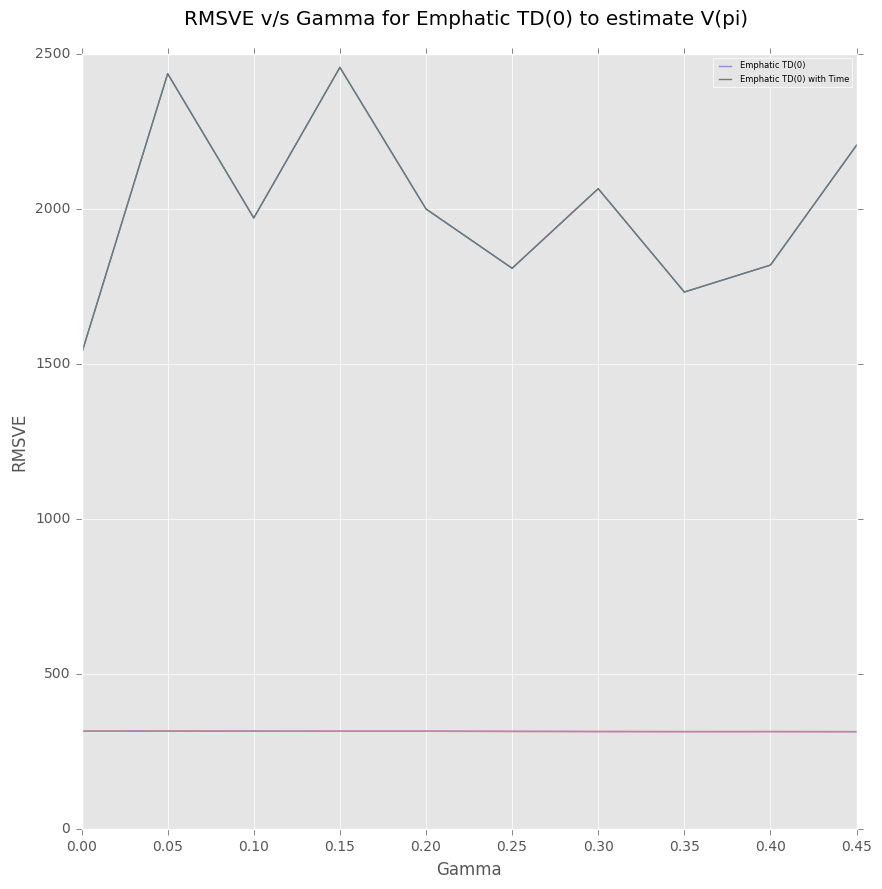

In [174]:
n_episodes = 40

gamma = np.zeros([10])
gamma[0] = 0

rmsve_emphatic_gradient_td_0 = np.zeros([10])
rmsve_emphatic_gradient_td_0_time = np.zeros([10])



eps = 0.1
alpha = 0.06
length_episode = 15
lambda_input = 0.0

print "### RMSVE vs Emphatic TD(0) for various values of the discount factor for estimating V(pi) using Function Approximation ###\n"
print "### Alpha = 0.06 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(gamma)):
    
    
    V, time_spent_state_1= emphatic_td_0(env, n_episodes,alpha,gamma[i],eps)
    rmsve_emphatic_gradient_td_0[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V))))

    
    #with time factor
    rmsve_emphatic_gradient_td_0_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V)),time_spent_state_1)))
    
    
    if i<9:
        
        gamma[i+1] = gamma[i] + 0.05

    
# Plot the above calculated statistics

plt.figure(figsize=(10,10))

plt.plot(gamma, rmsve_emphatic_gradient_td_0)
plt.plot(gamma, rmsve_emphatic_gradient_td_0_time)


plt.title("RMSVE v/s Gamma for Emphatic TD(0) to estimate V(pi) \n")
plt.xlabel('Gamma')
plt.ylabel('RMSVE')

plt.plot(gamma, rmsve_emphatic_gradient_td_0, label='Emphatic TD(0)')

plt.plot(gamma, rmsve_emphatic_gradient_td_0_time, label='Emphatic TD(0) with Time')

plt.legend(loc="best",prop={'size':6})

plt.show()

# Emphatic TD(lambda)  with interest function, followon traces; gamma and lambda as a function of the states!

In [200]:
"""
emphatic_td_lambda
"""

def emphatic_td_lambda(env, num_episodes, alpha, discount_factor, epsilon,lambda_input):
    """
    Provide the values of the number of episodes, the learning rate alpha, discount factor, epsilon
    """
    #initialise V for all states
    #initialise states for all V
    V = np.zeros(env.nS)
    interest_function = np.zeros(env.nS)
    theta = np.zeros(10)
    time_spent_state = np.zeros(env.nS)
    index_vector = np.zeros(10)
    
    GAMMA = np.zeros(env.nS)
    LAMBDA = np.zeros(env.nS)
    
    
    for g in range(len(index_vector)):
        index_vector[g] = g
        
    for s in range(len(V)):
        
        GAMMA[s] = np.random.uniform(0,1)
        LAMBDA[s] = np.random.uniform(0,1)
        
  
    

    # Plots
    stats = plotting.EpisodeStats(
        episode_lengths=np.zeros(num_episodes),
        episode_rewards=np.zeros(num_episodes))    
    
    # The policy we're following
    Q = defaultdict(lambda: np.zeros(env.action_space.n)) #maps states to actions
    policy = make_epsilon_greedy_policy(Q, epsilon, env.action_space.n) #behavior policy
    target_policy = create_greedy_policy(Q) #target policy
    rho = 1
    
    for i_episode in range(num_episodes):
        
        # reset state
        
        state = env.reset()

        
        state_scaled = float(state)/(env.nS-1)
        state_feature = np.zeros((10,))
        
        
        for i in range(len(state_feature)):
            
            state_feature[i] = math.cos(i*(math.pi)*state_scaled)
    
        
        etrace = np.zeros(10)
        
        # time step increment in the episode
        
        for t in itertools.count():
            
            for k in range(len(time_spent_state)):
                
                if state == k:
                    
                    time_spent_state[k] += 1
                    
                    
            action_probs = policy(state)
            action = np.random.choice(np.arange(len(action_probs)), p=action_probs)

            next_state, reward, done, _ = env.step(action)
            next_state_scaled = float(next_state)/(env.nS-1)
            next_state_feature = np.zeros((10,))
            
            for i in range(len(next_state_feature)):
                next_state_feature[i] = math.cos(i*(math.pi)*next_state_scaled)

            # Update statistics
            stats.episode_rewards[i_episode] += reward
            stats.episode_lengths[i_episode] = t
            
            
            action_target_policy = policy(next_state)
            rho = float(action_target_policy[action])/action_probs[action]
            
            # eligibility trace vectors and theta
            grad_v_cap = state_feature
            v_cap = np.dot(state_feature,theta)
            v_next_state = np.dot(next_state_feature,theta)
            
            
            interest_function = np.dot(index_vector,state_feature)


            if t == 0:
                F = interest_function
                etrace = np.zeros(10)
                M = 0
            
            delta = reward + GAMMA[state]*v_next_state - v_cap
            theta = theta + alpha * delta * etrace
            
            etrace = rho * (GAMMA[state]* LAMBDA[state]* etrace + M*state_feature)
            M = (LAMBDA[state] * interest_function) + (1- LAMBDA[state]) * F
            F = (rho * GAMMA[state] *F) + interest_function
            
            
            
                
            if done:
                break
                
            state = next_state
            
    for k in range(len(time_spent_state)):
        
        time_spent_state[k] = float(time_spent_state[k])/16
    
    #Calculate the V values for all the states
    II = np.zeros(env.nS)
    for j in range(len(V)):
        v_state_scaled = float(j)/(env.nS-1)
        v_state_feature = np.zeros(10)
        
        for i in range(len(v_state_feature)):
            v_state_feature[i] = math.cos(i*(math.pi)*v_state_scaled)
            
        
        V[j] = np.dot(v_state_feature,theta)
        II[j] = np.dot(index_vector,v_state_feature)

          

    
    
    return V, time_spent_state, II

# Sample Run for Emphatic TD(lambda)

### MSVE vs alpha for Emphatic TD(lambda) estimating V(pi) using Function Approximation ###

### eps = 0.1 || number of episodes = 40 ###

[ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
1.01135356025
-273.231806122
[ 0.14356222  0.14042504  0.13115061  0.11614428  0.09606188  0.07178111
  0.04436317  0.01500634 -0.01500634 -0.04436317 -0.07178111 -0.09606188
 -0.11614428 -0.13115061 -0.14042504 -0.14356222]
1.0114780735
-322.8842392
[ 0.00214971  0.00299188  0.00532784  0.00862086  0.01208663  0.01483828
  0.01605227  0.01512603  0.01179928  0.00621742 -0.00107485 -0.00920929
 -0.01712712 -0.0237469  -0.0281389  -0.02967655]
1.01141032588
-371.573571386
[ 0.1810014   0.16634307  0.12583743  0.06887822  0.00807675 -0.04424833
 -0.07925808 -0.09348603 -0.08895092 -0.07163386 -0.04900802 -0.02757264
 -0.01124262 -0.00103608  0.00404476  0.0055113 ]
1.01107840621
-221.15531318
[-0.02812798 -0.01183208  0.02503119  0.0546942   0.05294972  0.01637065
 -0.03433871 -0.06741 

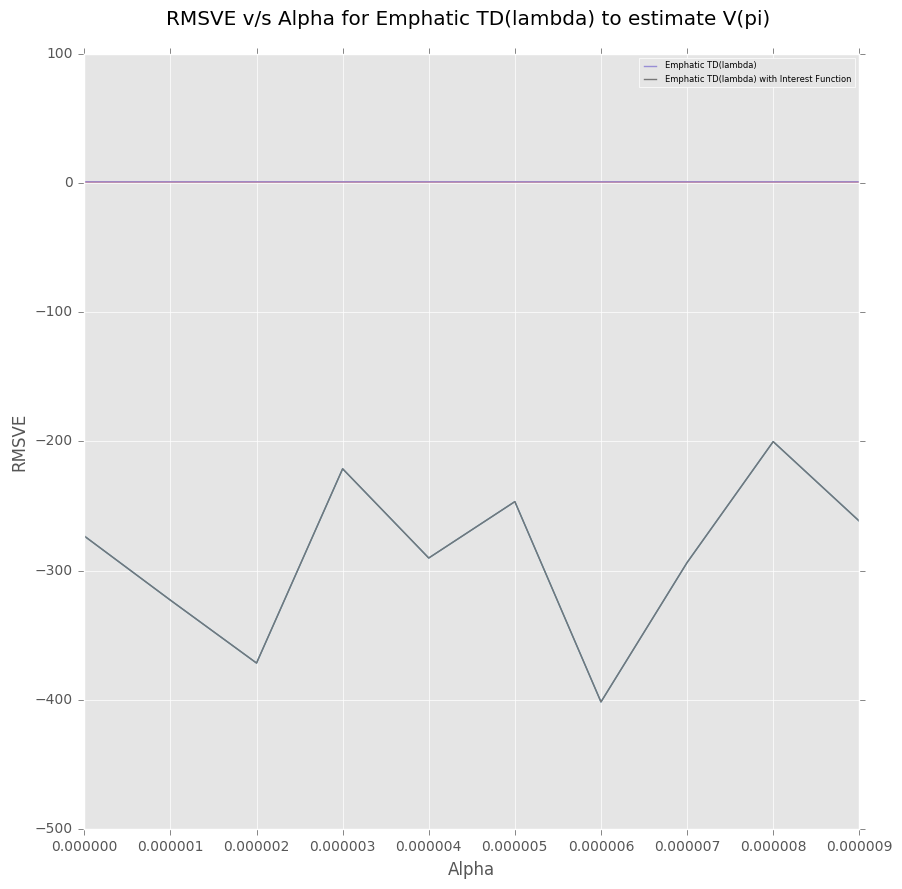

In [219]:
n_episodes = 40

alpha = np.zeros([10])
alpha[0] = 0.0

rmsve_emphatic_td = np.zeros([10])
rmsve_emphatic_td_time = np.zeros([10])

eps = 0.1
lambda_input = 1
gamma = 1


print "### MSVE vs alpha for Emphatic TD(lambda) estimating V(pi) using Function Approximation ###\n"
print "### eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
   
    V_e_td_lambda, time_spent_state_6, II = emphatic_td_lambda(env, n_episodes, alpha, gamma, eps,lambda_input)
    rmsve_emphatic_td[i] = np.sum(np.square(np.subtract(V_pi,V_e_td_lambda)))
    rmsve_emphatic_td[i] = float(rmsve_emphatic_td[i])/100000
    #math.sqrt(np.sum(np.square(np.subtract(V_pi,V_e_td_lambda))))
    print V_e_td_lambda
    print rmsve_emphatic_td[i]
    
    #with interest function in the RMSVE term
    a = np.square(np.subtract(V_pi,V_e_td_lambda))
    b = np.dot(a,II)
    c = np.multiply(b,time_spent_state_6)
    d = np.sum(c)
    rmsve_emphatic_td_time[i] = d
    rmsve_emphatic_td_time[i] = float(rmsve_emphatic_td_time[i])/100000
    print rmsve_emphatic_td_time[i]
    
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.000001

  
# Plot the above calculated statistics

plt.figure(figsize=(10,10))

plt.plot(alpha, rmsve_emphatic_td)
plt.plot(alpha, rmsve_emphatic_td_time)


plt.title("RMSVE v/s Alpha for Emphatic TD(lambda) to estimate V(pi) \n")
plt.xlabel('Alpha')
plt.ylabel('RMSVE')

plt.plot(alpha, rmsve_emphatic_td, label='Emphatic TD(lambda)')

plt.plot(alpha, rmsve_emphatic_td_time, label='Emphatic TD(lambda) with Interest Function')

plt.legend(loc="best",prop={'size':6})

plt.show()


# """"MORE RESULTS and GRAPHS""""

## Calculate the Root Mean Squared Error for Value functions across all states ||| The plots show the RMSVE for both with the time factor(d(s)) and without it.

# "RMSVE v/s Alpha for various methods to estimate V(pi)"

In [216]:
n_episodes = 40

alpha = np.zeros([10])
alpha[0] =  0.001 #0.001
rmsve_td_0_semi_gradient = np.zeros([10])
rmsve_td_lambda = np.zeros([10])
rmsve_mc_gradient = np.zeros([10])
rmsve_td_lambda_true_online = np.zeros([10])
rmsve_off_policy_semi_gradient_td_0 = np.zeros([10])
rmsve_mc_gradient_time = np.zeros([10])
rmsve_td_0_semi_gradient_time = np.zeros([10])
rmsve_td_lambda_true_online_time = np.zeros([10])
rmsve_td_lambda_time = np.zeros([10])
rmsve_td_0_off_time = np.zeros([10])
rmsve_emphatic_td = np.zeros([10])
rmsve_emphatic_td_0 = np.zeros([10])
rmsve_emphatic_td_0_time = np.zeros([10])

eps = 0.1
gamma = 0.45
length_episode = 15
lambda_input = 0.05

print "### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent_state_1= semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    V_mc, time_spent_state_2 = gradient_mc(env, n_episodes,alpha[i],gamma,eps,length_episode)
    V_td_lambda, time_spent_state_3 = semi_gradient_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    V_td_lambda_true_online, time_spent_state_4 = true_online_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    V_off_td_0, time_spent_state_5= off_policy_semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    
    rmsve_td_lambda_true_online[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda_true_online))))
    rmsve_td_0_semi_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V))))
    rmsve_mc_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_mc))))
    rmsve_td_lambda[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda))))
    rmsve_off_policy_semi_gradient_td_0[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_off_td_0))))

    V_e_td_lambda, time_spent_state_6,II = emphatic_td_lambda(env, n_episodes, alpha[i], gamma, eps,lambda_input)
    rmsve_emphatic_td[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_e_td_lambda))))
    
    V_e_td_0, time_spent_state_7 = emphatic_td_0(env, n_episodes, alpha[i], gamma, eps)
    rmsve_emphatic_td_0[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_e_td_0))))
    rmsve_emphatic_td_0_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_e_td_0)),time_spent_state_7)))
    


    
    #with time factor
    #rmsve_emphatic_td_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_e_td_lambda)),time_spent_state_6)))
    rmsve_td_0_semi_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V)),time_spent_state_1)))
    rmsve_mc_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_mc)),time_spent_state_2)))
    rmsve_td_lambda_true_online_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda_true_online)),time_spent_state_4)))
    rmsve_td_lambda_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda)),time_spent_state_3)))
    rmsve_td_0_off_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_off_td_0)),time_spent_state_5)))

    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_0_semi_gradient[i],"Semi-gradient TD(0)", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient[i], "Gradient Monte-Carlo", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_lambda[i],"Semi-gradient TD(lambda)", "\n"
    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient_time[i], "Gradient Monte-Carlo with time factor", "\n"
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.001 #0.001

    


### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###

### Gamma = 1 || eps = 0.1 || number of episodes = 40 ###



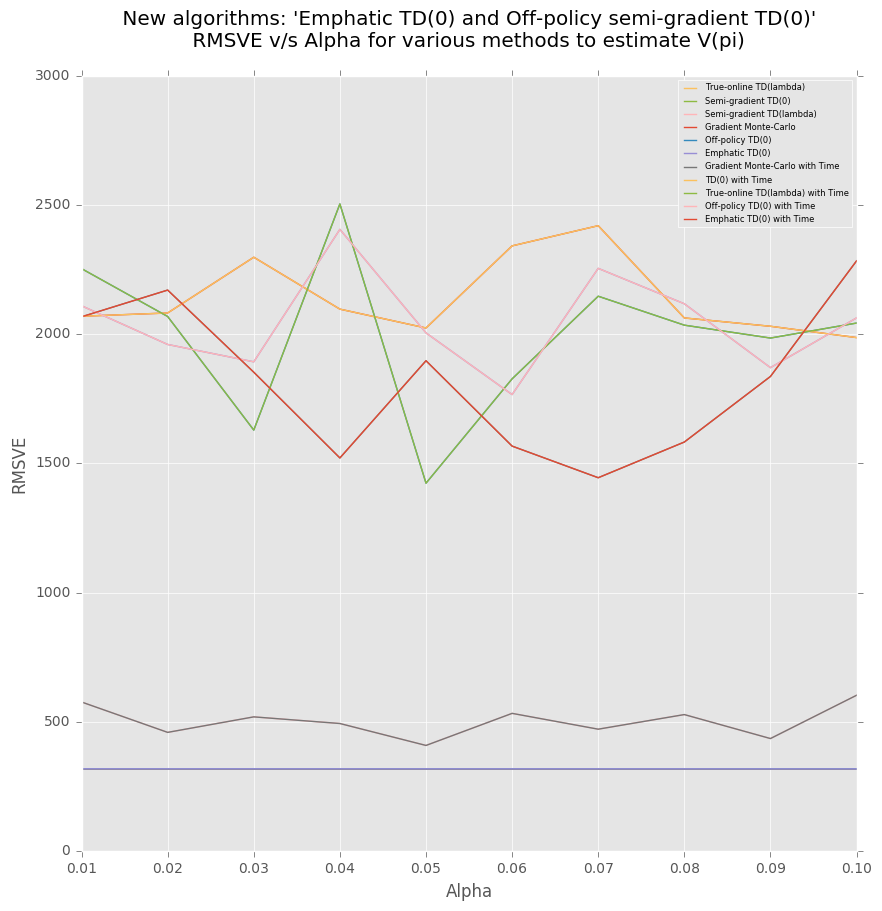

In [238]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))

plt.plot(alpha, rmsve_td_lambda_true_online)
plt.plot(alpha, rmsve_td_0_semi_gradient)
plt.plot(alpha, rmsve_td_lambda)
plt.plot(alpha, rmsve_mc_gradient)
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0)
plt.plot(alpha, rmsve_emphatic_td_0)
#plt.plot(alpha, rmsve_emphatic_td)


plt.plot(alpha, rmsve_mc_gradient_time)
plt.plot(alpha, rmsve_td_0_semi_gradient_time)
plt.plot(alpha, rmsve_td_lambda_true_online_time)
plt.plot(alpha, rmsve_td_0_off_time)
plt.plot(alpha,rmsve_emphatic_td_0_time)
#plt.plot(alpha, rmsve_td_lambda_time)

         
plt.title(" New algorithms: 'Emphatic TD(0) and Off-policy semi-gradient TD(0)' \n RMSVE v/s Alpha for various methods to estimate V(pi) \n")
plt.xlabel('Alpha')
plt.ylabel('RMSVE')

plt.plot(alpha, rmsve_td_lambda_true_online, label='True-online TD(lambda)')
plt.plot(alpha, rmsve_td_0_semi_gradient, label='Semi-gradient TD(0)')
plt.plot(alpha, rmsve_td_lambda, label='Semi-gradient TD(lambda)')
plt.plot(alpha, rmsve_mc_gradient, label='Gradient Monte-Carlo')
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0, label='Off-policy TD(0)')
plt.plot(alpha, rmsve_emphatic_td_0, label='Emphatic TD(0)')

plt.plot(alpha, rmsve_mc_gradient_time, label='Gradient Monte-Carlo with Time')
plt.plot(alpha, rmsve_td_0_semi_gradient_time, label='TD(0) with Time')
plt.plot(alpha, rmsve_td_lambda_true_online_time, label='True-online TD(lambda) with Time')
#plt.plot(alpha, rmsve_td_lambda_time, label='TD(lambda) with Time')
plt.plot(alpha, rmsve_td_0_off_time, label='Off-policy TD(0) with Time')

plt.plot(alpha, rmsve_emphatic_td_0_time, label='Emphatic TD(0) with Time')

#plt.plot(alpha, rmsve_emphatic_td, label='Emphatic TD(lambda)')

plt.legend(loc="best",prop={'size':6})

plt.show()

# RMSVE v/s Lambda for various methods to estimate V(pi) for smaller alphas

In [214]:
n_episodes = 40

alpha = np.zeros([100])
alpha[0] =  0.0001 #0.001
rmsve_td_0_semi_gradient = np.zeros([100])
rmsve_td_lambda = np.zeros([100])
rmsve_mc_gradient = np.zeros([100])
rmsve_td_lambda_true_online = np.zeros([100])
rmsve_off_policy_semi_gradient_td_0 = np.zeros([100])
rmsve_mc_gradient_time = np.zeros([100])
rmsve_td_0_semi_gradient_time = np.zeros([100])
rmsve_td_lambda_true_online_time = np.zeros([100])
rmsve_td_lambda_time = np.zeros([100])
rmsve_td_0_off_time = np.zeros([100])
rmsve_emphatic_td = np.zeros([100])
rmsve_emphatic_td_0 = np.zeros([100])
rmsve_emphatic_td_0_time = np.zeros([100])

eps = 0.1
gamma = 0.45
length_episode = 15
lambda_input = 0.05

print "### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent_state_1= semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    V_mc, time_spent_state_2 = gradient_mc(env, n_episodes,alpha[i],gamma,eps,length_episode)
    V_td_lambda, time_spent_state_3 = semi_gradient_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    V_td_lambda_true_online, time_spent_state_4 = true_online_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    V_off_td_0, time_spent_state_5= off_policy_semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    
    rmsve_td_lambda_true_online[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda_true_online))))
    rmsve_td_0_semi_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V))))
    rmsve_mc_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_mc))))
    rmsve_td_lambda[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda))))
    rmsve_off_policy_semi_gradient_td_0[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_off_td_0))))

    V_e_td_lambda, time_spent_state_6,II = emphatic_td_lambda(env, n_episodes, alpha[i], gamma, eps,lambda_input)
    rmsve_emphatic_td[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_e_td_lambda))))
    
    V_e_td_0, time_spent_state_7 = emphatic_td_0(env, n_episodes, alpha[i], gamma, eps)
    rmsve_emphatic_td_0[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_e_td_0))))
    rmsve_emphatic_td_0_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_e_td_0)),time_spent_state_7)))
    


    
    #with time factor
    #rmsve_emphatic_td_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_e_td_lambda)),time_spent_state_6)))
    rmsve_td_0_semi_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V)),time_spent_state_1)))
    rmsve_mc_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_mc)),time_spent_state_2)))
    rmsve_td_lambda_true_online_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda_true_online)),time_spent_state_4)))
    rmsve_td_lambda_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda)),time_spent_state_3)))
    rmsve_td_0_off_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_off_td_0)),time_spent_state_5)))

    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_0_semi_gradient[i],"Semi-gradient TD(0)", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient[i], "Gradient Monte-Carlo", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_lambda[i],"Semi-gradient TD(lambda)", "\n"
    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient_time[i], "Gradient Monte-Carlo with time factor", "\n"
    
    if i<99:
        
        alpha[i+1] = alpha[i] + 0.0001 #0.001

    


### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###

### Gamma = 1 || eps = 0.1 || number of episodes = 40 ###



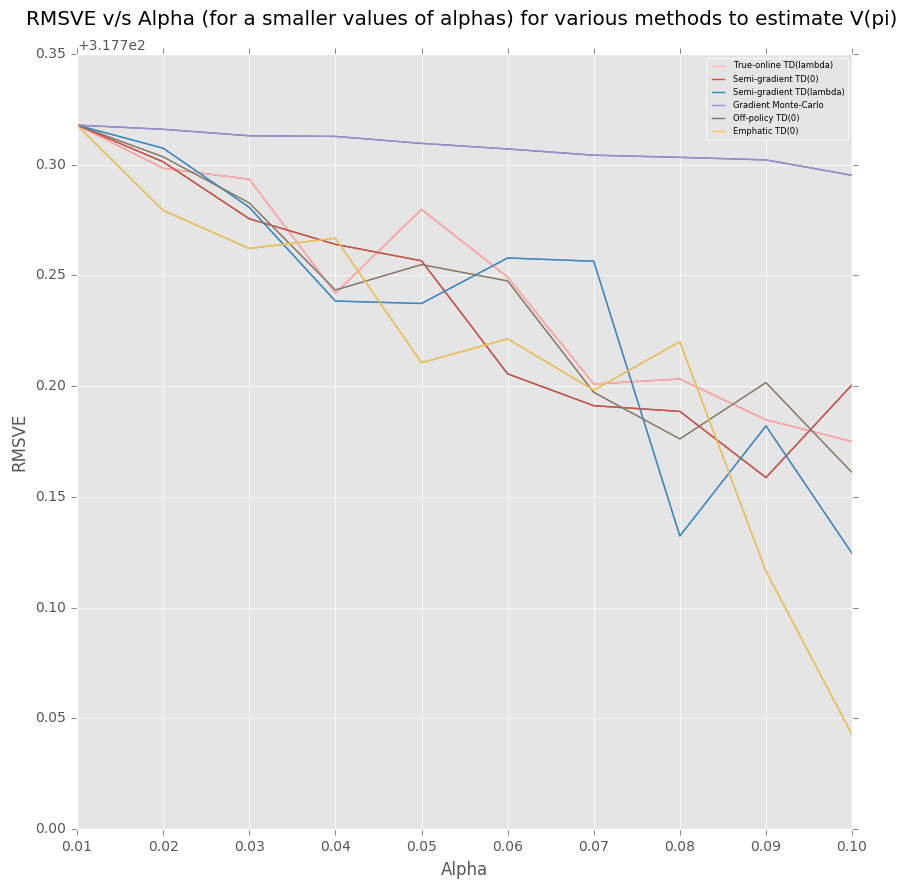

In [239]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))

plt.plot(alpha, rmsve_td_lambda_true_online)
plt.plot(alpha, rmsve_td_0_semi_gradient)
plt.plot(alpha, rmsve_td_lambda)
plt.plot(alpha, rmsve_mc_gradient)
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0)
plt.plot(alpha, rmsve_emphatic_td_0)
#plt.plot(alpha, rmsve_emphatic_td)

'''
plt.plot(alpha, rmsve_mc_gradient_time)
plt.plot(alpha, rmsve_td_0_semi_gradient_time)
plt.plot(alpha, rmsve_td_lambda_true_online_time)
plt.plot(alpha, rmsve_td_0_off_time)
plt.plot(alpha,rmsve_emphatic_td_0_time)
#plt.plot(alpha, rmsve_td_lambda_time)
'''
         
plt.title("RMSVE v/s Alpha (for a smaller values of alphas) for various methods to estimate V(pi) \n")
plt.xlabel('Alpha')
plt.ylabel('RMSVE')

plt.plot(alpha, rmsve_td_lambda_true_online, label='True-online TD(lambda)')
plt.plot(alpha, rmsve_td_0_semi_gradient, label='Semi-gradient TD(0)')
plt.plot(alpha, rmsve_td_lambda, label='Semi-gradient TD(lambda)')
plt.plot(alpha, rmsve_mc_gradient, label='Gradient Monte-Carlo')
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0, label='Off-policy TD(0)')
plt.plot(alpha, rmsve_emphatic_td_0, label='Emphatic TD(0)')
'''
plt.plot(alpha, rmsve_mc_gradient_time, label='Gradient Monte-Carlo with Time')
plt.plot(alpha, rmsve_td_0_semi_gradient_time, label='TD(0) with Time')
plt.plot(alpha, rmsve_td_lambda_true_online_time, label='True-online TD(lambda) with Time')
#plt.plot(alpha, rmsve_td_lambda_time, label='TD(lambda) with Time')
plt.plot(alpha, rmsve_td_0_off_time, label='Off-policy TD(0) with Time')

plt.plot(alpha, rmsve_emphatic_td_0_time, label='Emphatic TD(0) with Time')

#plt.plot(alpha, rmsve_emphatic_td, label='Emphatic TD(lambda)')
'''
plt.legend(loc="best",prop={'size':6})

plt.show()

# # RMSVE v/s Alphas for various methods to estimate V(pi): Emphatic TD(lambda) introduced

In [228]:
n_episodes = 40

alpha = np.zeros([10])
alpha[0] =  0 
rmsve_td_0_semi_gradient = np.zeros([10])
rmsve_td_lambda = np.zeros([10])
rmsve_mc_gradient = np.zeros([10])
rmsve_td_lambda_true_online = np.zeros([10])
rmsve_off_policy_semi_gradient_td_0 = np.zeros([10])
rmsve_mc_gradient_time = np.zeros([10])
rmsve_td_0_semi_gradient_time = np.zeros([10])
rmsve_td_lambda_true_online_time = np.zeros([10])
rmsve_td_lambda_time = np.zeros([10])
rmsve_td_0_off_time = np.zeros([10])
rmsve_emphatic_td = np.zeros([10])
rmsve_emphatic_td_0 = np.zeros([10])
rmsve_emphatic_td_0_time = np.zeros([10])

eps = 0.1
gamma = 0.45
length_episode = 15
lambda_input = 0.05

print "### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(alpha)):
    
    
    V, time_spent_state_1= semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    V_mc, time_spent_state_2 = gradient_mc(env, n_episodes,alpha[i],gamma,eps,length_episode)
    V_td_lambda, time_spent_state_3 = semi_gradient_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    V_td_lambda_true_online, time_spent_state_4 = true_online_td_lambda(env, n_episodes,alpha[i],gamma,eps,lambda_input)
    V_off_td_0, time_spent_state_5= off_policy_semi_gradient_td_0(env, n_episodes,alpha[i],gamma,eps)
    
    rmsve_td_lambda_true_online[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda_true_online))))
    rmsve_td_0_semi_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V))))
    rmsve_mc_gradient[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_mc))))
    rmsve_td_lambda[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda))))
    rmsve_off_policy_semi_gradient_td_0[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_off_td_0))))

    V_e_td_lambda, time_spent_state_6,II = emphatic_td_lambda(env, n_episodes, alpha[i], gamma, eps,lambda_input)
    rmsve_emphatic_td[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_e_td_lambda))))
    
    V_e_td_0, time_spent_state_7 = emphatic_td_0(env, n_episodes, alpha[i], gamma, eps)
    rmsve_emphatic_td_0[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_e_td_0))))
    rmsve_emphatic_td_0_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_e_td_0)),time_spent_state_7)))
    


    
    #with time factor
    #rmsve_emphatic_td_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_e_td_lambda)),time_spent_state_6)))
    rmsve_td_0_semi_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V)),time_spent_state_1)))
    rmsve_mc_gradient_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_mc)),time_spent_state_2)))
    rmsve_td_lambda_true_online_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda_true_online)),time_spent_state_4)))
    rmsve_td_lambda_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda)),time_spent_state_3)))
    rmsve_td_0_off_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_off_td_0)),time_spent_state_5)))

    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_0_semi_gradient[i],"Semi-gradient TD(0)", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient[i], "Gradient Monte-Carlo", "\n"
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_td_lambda[i],"Semi-gradient TD(lambda)", "\n"
    
    #print "The RMSVE for alpha=", alpha[i], "is", rmsve_mc_gradient_time[i], "Gradient Monte-Carlo with time factor", "\n"
    
    if i<9:
        
        alpha[i+1] = alpha[i] + 0.000001 #0.001

    


### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###

### Gamma = 1 || eps = 0.1 || number of episodes = 40 ###



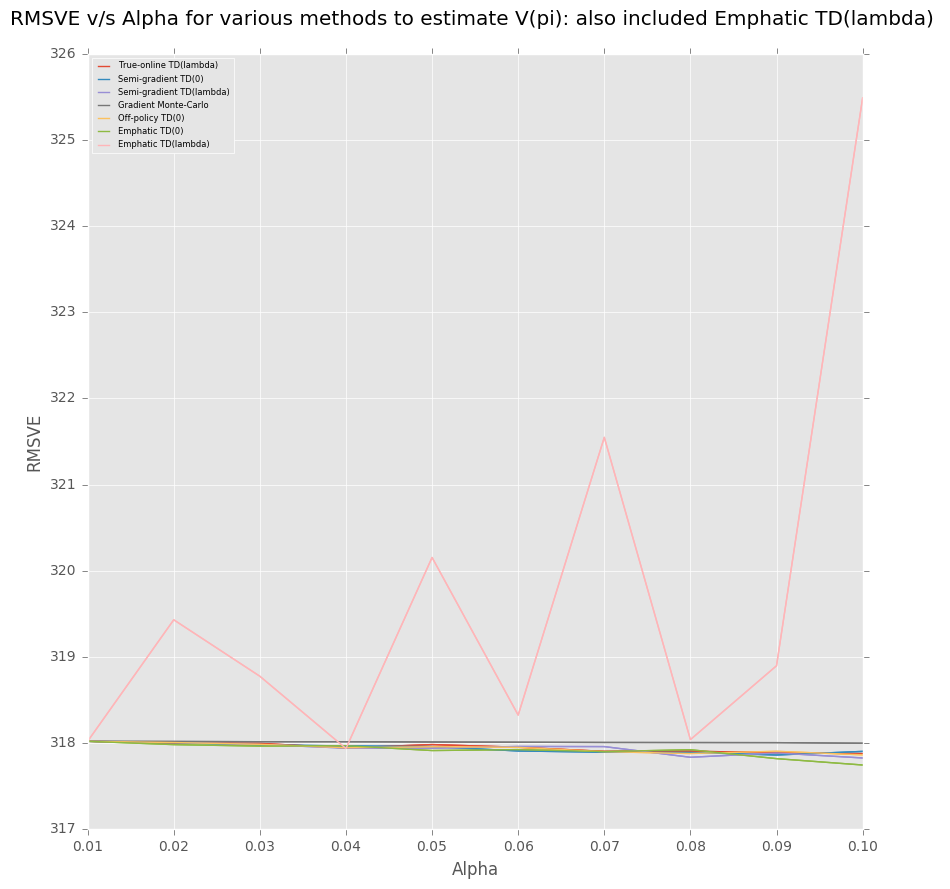

In [240]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))

plt.plot(alpha, rmsve_td_lambda_true_online)
plt.plot(alpha, rmsve_td_0_semi_gradient)
plt.plot(alpha, rmsve_td_lambda)
plt.plot(alpha, rmsve_mc_gradient)
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0)
plt.plot(alpha, rmsve_emphatic_td_0)
plt.plot(alpha, rmsve_emphatic_td)

'''
plt.plot(alpha, rmsve_mc_gradient_time)
plt.plot(alpha, rmsve_td_0_semi_gradient_time)
plt.plot(alpha, rmsve_td_lambda_true_online_time)
plt.plot(alpha, rmsve_td_0_off_time)
plt.plot(alpha,rmsve_emphatic_td_0_time)
#plt.plot(alpha, rmsve_td_lambda_time)
'''
         
plt.title("RMSVE v/s Alpha for various methods to estimate V(pi): also included Emphatic TD(lambda) \n")
plt.xlabel('Alpha')
plt.ylabel('RMSVE')

plt.plot(alpha, rmsve_td_lambda_true_online, label='True-online TD(lambda)')
plt.plot(alpha, rmsve_td_0_semi_gradient, label='Semi-gradient TD(0)')
plt.plot(alpha, rmsve_td_lambda, label='Semi-gradient TD(lambda)')
plt.plot(alpha, rmsve_mc_gradient, label='Gradient Monte-Carlo')
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0, label='Off-policy TD(0)')
plt.plot(alpha, rmsve_emphatic_td_0, label='Emphatic TD(0)')
plt.plot(alpha, rmsve_emphatic_td, label='Emphatic TD(lambda)')
'''
plt.plot(alpha, rmsve_mc_gradient_time, label='Gradient Monte-Carlo with Time')
plt.plot(alpha, rmsve_td_0_semi_gradient_time, label='TD(0) with Time')
plt.plot(alpha, rmsve_td_lambda_true_online_time, label='True-online TD(lambda) with Time')
#plt.plot(alpha, rmsve_td_lambda_time, label='TD(lambda) with Time')
plt.plot(alpha, rmsve_td_0_off_time, label='Off-policy TD(0) with Time')
plt.plot(alpha, rmsve_emphatic_td_0_time, label='Emphatic TD(0) with Time')

'''
plt.legend(loc="best",prop={'size':6})

plt.show()

# RMSVE v/s Alphas for various methods to estimate V(pi): Algorithms compared exclusively mentioned in the paper:
1. Semi-gradient TD(0)
2. Off-policy TD(0)
3. Emphatic TD(0)
4. Emphatic TD(lambda)

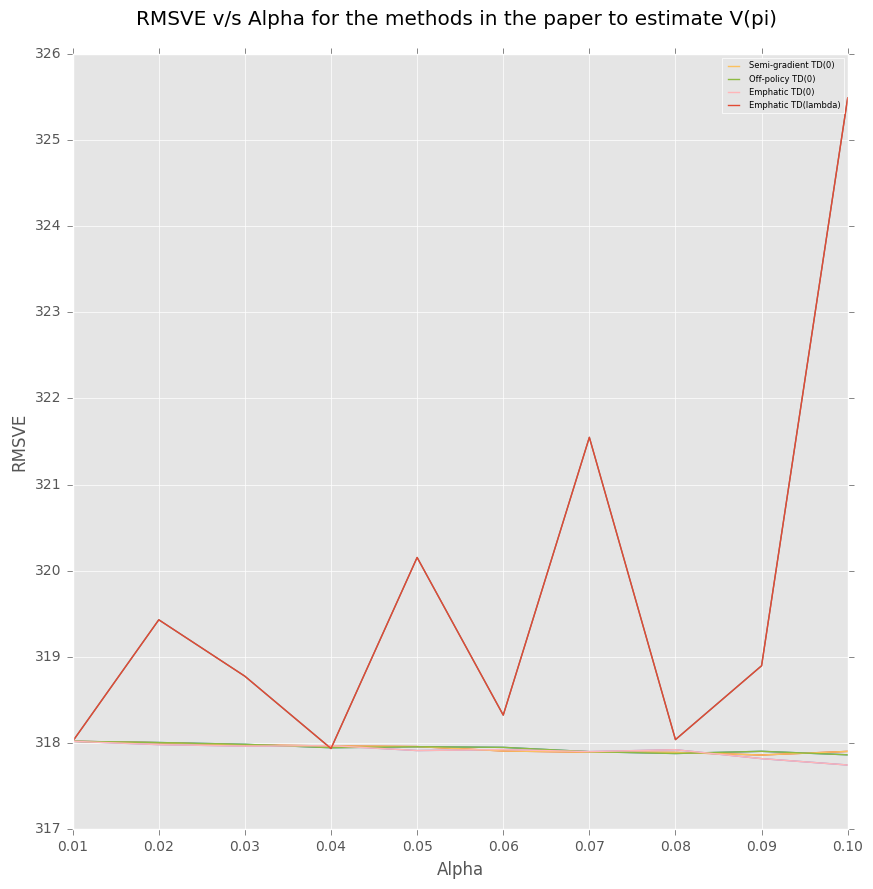

In [241]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))

#plt.plot(alpha, rmsve_td_lambda_true_online)
plt.plot(alpha, rmsve_td_0_semi_gradient)
#plt.plot(alpha, rmsve_td_lambda)
#plt.plot(alpha, rmsve_mc_gradient)
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0)
plt.plot(alpha, rmsve_emphatic_td_0)
plt.plot(alpha, rmsve_emphatic_td)

'''
plt.plot(alpha, rmsve_mc_gradient_time)
plt.plot(alpha, rmsve_td_0_semi_gradient_time)
plt.plot(alpha, rmsve_td_lambda_true_online_time)
plt.plot(alpha, rmsve_td_0_off_time)
plt.plot(alpha,rmsve_emphatic_td_0_time)
#plt.plot(alpha, rmsve_td_lambda_time)
'''
         
plt.title("RMSVE v/s Alpha for the methods in the paper to estimate V(pi) \n")
plt.xlabel('Alpha')
plt.ylabel('RMSVE')

#plt.plot(alpha, rmsve_td_lambda_true_online, label='True-online TD(lambda)')
plt.plot(alpha, rmsve_td_0_semi_gradient, label='Semi-gradient TD(0)')
#plt.plot(alpha, rmsve_td_lambda, label='Semi-gradient TD(lambda)')
#plt.plot(alpha, rmsve_mc_gradient, label='Gradient Monte-Carlo')
plt.plot(alpha, rmsve_off_policy_semi_gradient_td_0, label='Off-policy TD(0)')
plt.plot(alpha, rmsve_emphatic_td_0, label='Emphatic TD(0)')
plt.plot(alpha, rmsve_emphatic_td, label='Emphatic TD(lambda)')
'''
plt.plot(alpha, rmsve_mc_gradient_time, label='Gradient Monte-Carlo with Time')
plt.plot(alpha, rmsve_td_0_semi_gradient_time, label='TD(0) with Time')
plt.plot(alpha, rmsve_td_lambda_true_online_time, label='True-online TD(lambda) with Time')
#plt.plot(alpha, rmsve_td_lambda_time, label='TD(lambda) with Time')
plt.plot(alpha, rmsve_td_0_off_time, label='Off-policy TD(0) with Time')
plt.plot(alpha, rmsve_emphatic_td_0_time, label='Emphatic TD(0) with Time')

'''
plt.legend(loc="best",prop={'size':6})

plt.show()

# RMSVE v/s Lambda for various methods to estimate V(pi)

In [21]:
###### TD(lambda) and True-online TD(lambda)



n_episodes = 40

lambda_input = np.zeros([10])
lambda_input[0] = 0.0
rmsve_td_lambda = np.zeros([10])
rmsve_td_lambda_true_online = np.zeros([10])

rmsve_td_lambda_true_online_time = np.zeros([10])
rmsve_td_lambda_time = np.zeros([10])

eps = 0.1
gamma = 1
length_episode = 10

alpha = 0.01

print "### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###\n"
print "### Gamma = 1 || eps = 0.1 || number of episodes =",n_episodes,"###\n"

for i in range(len(lambda_input)):
    
    
    V_td_lambda,time_spent_state_3 = semi_gradient_td_lambda(env, n_episodes,alpha,gamma,eps,lambda_input[i])
    V_td_lambda_true_online,time_spent_state_4 = true_online_td_lambda(env, n_episodes,alpha,gamma,eps,lambda_input[i])
    
    rmsve_td_lambda[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda))))
    rmsve_td_lambda_true_online[i] = math.sqrt(np.sum(np.square(np.subtract(V_pi,V_td_lambda_true_online))))
    
    rmsve_td_lambda_true_online_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda_true_online)),time_spent_state_4)))
    rmsve_td_lambda_time[i] = np.sqrt(np.sum(np.multiply(np.square(np.subtract(V_pi,V_td_lambda)),time_spent_state_3)))
    
    
    #print "The RMSVE for lambda=", lambda_input[i], "is", rmsve_td_lambda[i],"for Semi-gradient TD(lambda)", "\n"
    
    if i<9:
        
        lambda_input[i+1] = lambda_input[i] + 0.01

    


### Various algorithms for estimating V(pi) using Function Approximation for TD Learning###

### Gamma = 1 || eps = 0.1 || number of episodes = 40 ###



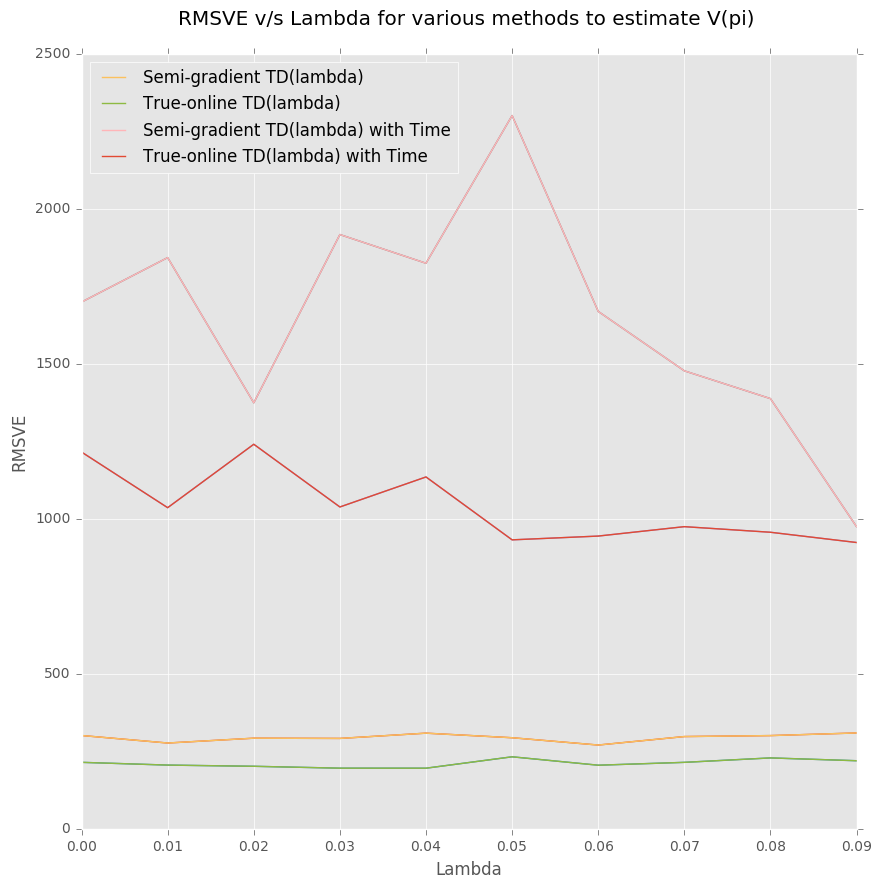

In [22]:
# Plot the above calculated statistics

plt.figure(figsize=(10,10))
    
plt.plot(lambda_input, rmsve_td_lambda)
plt.plot(lambda_input, rmsve_td_lambda_true_online)
plt.plot(lambda_input, rmsve_td_lambda_true_online_time)
plt.plot(lambda_input, rmsve_td_lambda_time)

plt.title("RMSVE v/s Lambda for various methods to estimate V(pi) \n")
plt.xlabel('Lambda')
plt.ylabel('RMSVE')

plt.plot(lambda_input, rmsve_td_lambda, label='Semi-gradient TD(lambda)')
plt.plot(lambda_input, rmsve_td_lambda_true_online, label='True-online TD(lambda)')

plt.plot(lambda_input, rmsve_td_lambda_time, label='Semi-gradient TD(lambda) with Time')
plt.plot(lambda_input, rmsve_td_lambda_true_online_time, label='True-online TD(lambda) with Time')


plt.legend(loc="best")

plt.show()

# Results and Intuition:

From the above graphs and implementation:

1. A constant value of RMSVE is obtained for Emphatic TD(0) and is comparable to the other methods from Assignment 4.
2. Emphatic TD(lambda) is NOT at all stable and blows up as soon as there is a small increment in the learning rate "alpha". Also, note that the learning rate alpha is of the order of 10e-5; which is really very small. For this environment, Ekphatic TD(lambda) does not produce reliable results. This can be due to the sparsity introduced by the interest function (as it is an arbitrary function). And, for the case whe RMSVE includes the interets function term, Emphatic TD(lambda) does not converge.
3. We notice that the off-policy Emphatic TD(0) performs the BEST amongst all the methods presented in this and the previous assignment.
4. Interestingly, off-policy semi-gradient TD(0) performs good too and has results comparable with Emphatic TD(0).
5. Emphatic TD(0) performs the BEST. This can be attributed to convergence guarantee and the stability of the update equations!



Also, see the results from the previous assignment:

1. The TD(0) method's solution is used to calculate the RMSVE.
2. The error is weighted by the amount of time spent in the state. This helps in giving a true estimate how of eahc state contibutes to the error of the Value function. This is advisable because it helps to identify which states are the culprits!
3. For the given environment, one has to choose the alpha and lambda values correctly. A good estimate for V(s) is obtained when alpha=0.01 and lambda between 0.04 and 0.05. Also, note that the number of episodes to obtain the RMSVE is 40
4. From the second graph, we can see that the True-online TD(lambda) method ourperforms the Semi-gradient TD(lmabda) by a margin of error of around 70. Also, for the time weighted RMSVE we again see that the True-online TD(lambda) method ourperforms the Semi-gradient TD(lmabda). This time by a margin of error of around 800! This result can be attributed to a good stability with respect to the step-size. Also, in the case of True-online there is no overhead of deciding between accumulate and replace TD.
5. In graph one, we can see that True-online TD(lambda) performs the best and the Semi-gradient TD(0) performs the worst. Interestingly, Semi-gradient TD(lambda) gives results close to True-online TD(lambda). We can see the effect of the elgibility trace vector in action!
6. Thus the backward view of the True-online method and the Dutch Trace vector improves the performance over the other methods. The eligibility(dutch) trace keeps track of which components of the weight vector have contributed, positively or negatively, to recent state valuations.
 


# Future possibilities:

Define a good notion of the Lambda, Gamma and the interest function. Since, these are some functions of the states; it is possible to generate a wide variety of such functions! This will then affect the followon trace.

1. Try out a non-linear function approximator. Perhaps, a simple feedforward neural network for FA
2. Try out various basis functions for Linear FA.
3. Give a more comprehensive analysis of alphas and lambda values with a convergence guarantee.
4. Try out more environments.


# The End